<a href="https://colab.research.google.com/github/MariaZharova/Skillfactory_projects/blob/main/MFTIDS%20/NLP_lectures/%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_9_NER_BERT_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER example using BERT

You can download dataset from [here](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus#ner_dataset.csv)

In [ ]:
!pip install seqeval
# !pip install transformers==2.6.0

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
import transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import (
    BertTokenizer, BertConfig, AutoTokenizer, AdamW,
    get_linear_schedule_with_warmup, BertForTokenClassification
)
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score

%matplotlib inline
torch.__version__

'2.4.1+cu121'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path to dataset in your google-drive
PATH = '/content/drive/MyDrive/Colab Notebooks/NER_example/ner_dataset.csv'

data = pd.read_csv(PATH, header=None, encoding= 'unicode_escape')
data = data.fillna(method="ffill")
data = data.rename(columns=data.iloc[0]).drop(data.index[0])
data.replace('', np.nan, regex=True, inplace = True)
data["Sentence #"].fillna(method="ffill", inplace = True)
data.tail(10)

<ipython-input-4-43e477c0ac8e>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")
<ipython-input-4-43e477c0ac8e>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Sentence #"].fillna(method="ffill", inplace = True)
<ipython-input-4-43e477c0ac8e>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Sentence #"]

,Sentence #,Word,POS,Tag
1048566,Sentence: 47958,impact,NN,O
1048567,Sentence: 47958,.,.,O
1048568,Sentence: 47959,Indian,JJ,B-gpe
1048569,Sentence: 47959,forces,NNS,O
1048570,Sentence: 47959,said,VBD,O
1048571,Sentence: 47959,they,PRP,O
1048572,Sentence: 47959,responded,VBD,O
1048573,Sentence: 47959,to,TO,O
1048574,Sentence: 47959,the,DT,O
1048575,Sentence: 47959,attack,NN,O


## Data Preprocessing

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[f"Sentence: {self.n_sent}"]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(data)

<ipython-input-5-76a8cf44a7c3>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[25]

['Three',
 'major',
 'banks',
 'have',
 'collapsed',
 ',',
 'unemployment',
 'has',
 'soared',
 ',',
 'and',
 'the',
 'value',
 'of',
 'the',
 'krona',
 'has',
 'plunged',
 '.']

In [ ]:
labels = [[s[2] for s in sent] for sent in getter.sentences]
print(labels[10])

['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-geo', 'I-geo', 'O', 'B-per', 'O', 'B-per', 'I-per', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

## Tokenization

In [ ]:
MAX_LEN = 75 # Sentence Max length
bs = 32 # Batch size

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
tokenized_texts_and_labels = list()

for sent, labs in tqdm(zip(sentences, labels)):
  tokenized_texts_and_labels.append(tokenize_and_preserve_labels(sent, labs))

47959it [00:43, 1098.21it/s]


In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
print(tokenized_texts[10])
print(labels[10])

['In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'F', '##ou', '##ad', 'Sin', '##ior', '##a', 'said', 'the', 'Lebanese', 'people', 'are', 're', '##sol', '##ute', 'in', 'preventing', 'such', 'attempts', 'from', 'destroying', 'their', 'spirit', '.']
['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-geo', 'I-geo', 'O', 'B-per', 'O', 'B-per', 'B-per', 'B-per', 'I-per', 'I-per', 'I-per', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

### Setup the Bert model for finetuning

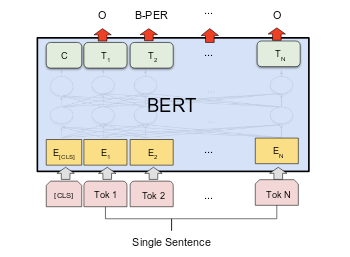

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre-trained bert-base-cased model and provide the number of possible labels.

In [ ]:
len(tag2idx)

18

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Finetune Bert

First we define some metrics, we want to track while training. We use the f1_score from the seqeval package. You ca find more details here. And we use simple accuracy on a token level comparable to the accuracy in keras.

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average train loss: {avg_train_loss}")

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print(f"Validation loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy/nb_eval_steps}")
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print(f"Validation F1-Score: {f1_score([pred_tags], [valid_tags])}")
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.07718869102421494
Validation loss: 0.04743034950147072
Validation Accuracy: 0.9853273809523813


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  33%|███▎      | 1/3 [09:55<19:51, 595.78s/it]

Validation F1-Score: 0.8070122594054038

Average train loss: 0.03819438865031354
Validation loss: 0.04400770245740811
Validation Accuracy: 0.9865246031746038


Epoch:  67%|██████▋   | 2/3 [19:50<09:55, 595.37s/it]

Validation F1-Score: 0.8205189740512975

Average train loss: 0.02876874478223193
Validation loss: 0.042967123575508595
Validation Accuracy: 0.9869162698412701


Epoch: 100%|██████████| 3/3 [29:45<00:00, 595.19s/it]

Validation F1-Score: 0.8262829507120041



## Visualize the training loss

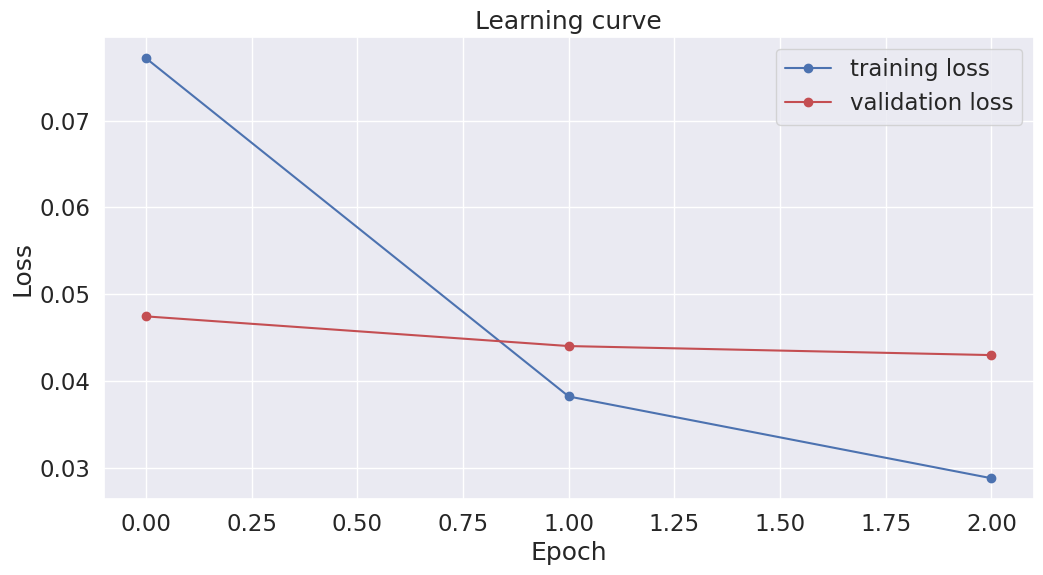

In [37]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Apply the model to new sentence

In [32]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a
reporter for the network, about protests in Minnesota and elsewhere.
"""

In [33]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [34]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [35]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [36]:
for token, label in zip(new_tokens, new_labels):
    print(f"{label}\t{token}")

O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]
